# Image similarity example

## Setup

In [1]:
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore")
import tiledb
import PIL

from tiledb.vector_search.object_api import object_index
from tiledb.vector_search.object_readers import DirectoryImageReader
from tiledb.vector_search.embeddings import ImageResNetV2Embedding

dataset = "tf_flowers_directory"
base_uri = f"/tmp/{dataset}_demo"
config = {}
image_array_uri = f"{base_uri}/tf_flowers"
index_uri = f"{base_uri}/index"
vfs = tiledb.VFS(config=config)

In [2]:
if vfs.is_dir(base_uri):
    vfs.remove_dir(base_uri)
vfs.create_dir(base_uri)

## Download images

In [3]:
!mkdir /tmp/tf_flowers_directory_demo/images
!wget -qO- https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz | tar xz -C /tmp/tf_flowers_directory_demo/images

# Create vector search index

In [ ]:
reader = DirectoryImageReader(
    uri=f"{base_uri}/images", 
    glob="**/[!.]*", 
    suffixes=[".jpg"],
    config=config)
embedding = ImageResNetV2Embedding()

if vfs.is_dir(index_uri):
    vfs.remove_dir(index_uri)

index = object_index.create(
    uri=index_uri,
    index_type="IVF_FLAT",
    object_reader=reader,
    embedding=embedding,
    config=config,
)
index.update_index(
    files_per_partition=800,
    max_tasks_per_stage=5,
    workers=5,
)
index = object_index.ObjectIndex(uri=index_uri)

# Query

Pick a random image from the dataset

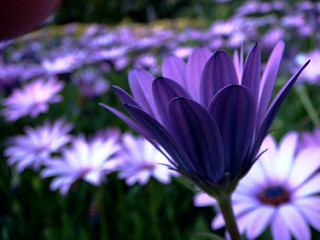

Class: daisy


In [5]:
def display_image(images, image_id):
    display(PIL.Image.fromarray(np.reshape(images["image"][image_id], images["shape"][image_id])))
def display_related_image(images, image_id, related_image_id):
    display(PIL.Image.fromarray(np.reshape(images["image"][image_id, related_image_id], images["shape"][image_id, related_image_id])))
def class_from_file_path(file_path: str):
    split_path = file_path.split("/")
    return split_path[len(split_path)-2]
index = object_index.ObjectIndex(index_uri, config=config)

# rid = random.randint(0,3600)
rid = 42
query_image = index.object_reader.read_objects_by_external_ids([rid])

with tiledb.open(f"{index_uri}/object_metadata", mode='r', config=config) as A:
    query_metadata = A[rid]
    query_file_path = query_metadata['file_path'][0]
display_image(query_image, 0)
query_class = class_from_file_path(query_file_path)
print(f"Class: {query_class}")

## Similarity query

1/1 [==============================] - 1s 540ms/step


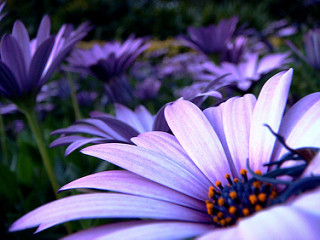

Class: daisy


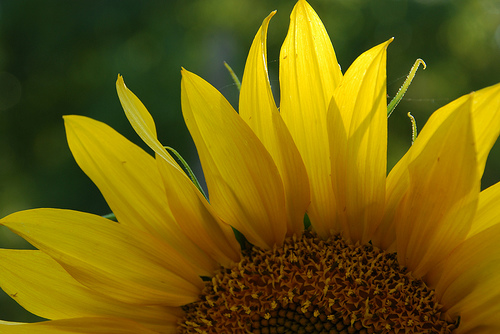

Class: sunflowers


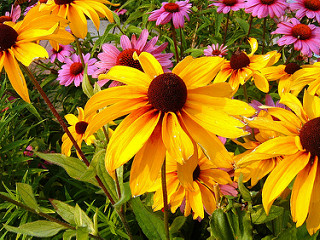

Class: sunflowers


In [6]:
distances, images, metadata = index.query(
                                        query_image, 
                                        k=4, 
                                        nprobe=10
                                    )

for image_id in range(images['image'].shape[0]):
    for related_image_id in range(1, images['image'].shape[1]):
        display_related_image(images, image_id, related_image_id)
        print(f"Class: {class_from_file_path(metadata['file_path'][image_id, related_image_id])}")

## Similarity query with structured restrict

Find similar images from the same flower class

1/1 [==============================] - 0s 75ms/step


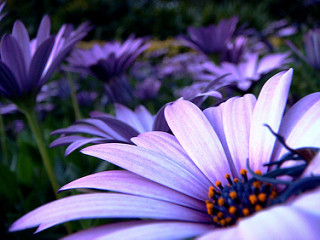

Class: daisy


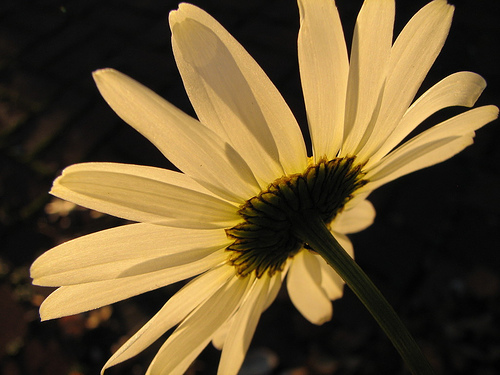

Class: daisy


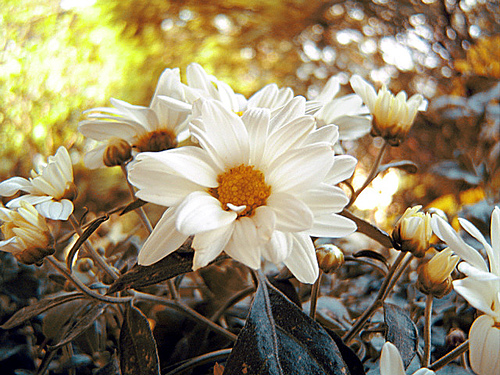

Class: daisy


In [7]:
def filter_fn(row):
    return query_class in row['file_path']
distances, images, metadata = index.query(
                                        query_image, 
                                        k=4, 
                                        metadata_df_filter_fn=filter_fn,
                                        nprobe=10
                                    )

for image_id in range(images['image'].shape[0]):
    for related_image_id in range(1, images['image'].shape[1]):
        display_related_image(images, image_id, related_image_id)
        print(f"Class: {class_from_file_path(metadata['file_path'][image_id, related_image_id])}")